In [1]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from statsmodels.tsa.arima.model import ARIMA as ARIMA

<p style = "font-size: 30px; color: brown">Data Preparation</p>

In [2]:
# Import Data, Train & Holiday_Events
store = pd.read_csv("store-sales-time-series-forecasting/train.csv")
holiday_events = pd.read_excel("store-sales-time-series-forecasting/holidays_events.xlsx")

print(store.head())
print("\n")
print(holiday_events.head())

   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0


        date     type  transferred
0 2012-03-02  Holiday        False
1 2012-04-01  Holiday        False
2 2012-04-12  Holiday        False
3 2012-04-14  Holiday        False
4 2012-04-21  Holiday        False


In [3]:
# Clean Data, Keep 'date' & 'type'
holiday_events = holiday_events[['date', 'type']]

# Change all 'type' Object to Float 1
holiday_events['type'] = 1

# Change 'type' to 'holiday'
holiday_events = holiday_events.rename(columns={'type': 'holiday'})

# Change Object to DateTime64
store['date'] = pd.to_datetime(store['date'])

# Compile Data
csv = pd.merge(store, holiday_events, on='date', how='outer')
csv = csv.fillna(0)

# Clean Data, Keep any food related 'family'
csv = csv[(csv['family'] == 'BREAD/BAKERY') |
          (csv['family'] == 'DAIRY') |
          (csv['family'] == 'DELI') |
          (csv['family'] == 'EGGS') |
          (csv['family'] == 'FROZEN FOODS') |
          (csv['family'] == 'MEATS') | 
          (csv['family'] == 'POULTRY') |
          (csv['family'] == 'PREPARED FOODS') | 
          (csv['family'] == 'PRODUCE') |
          (csv['family'] == 'SEAFOOD')]

# Clean Data, Keep 'store_nbr' related to Quito
csv = csv[(csv['store_nbr'] == 1.0) |
          (csv['store_nbr'] == 2.0) |
          (csv['store_nbr'] == 3.0) |
          (csv['store_nbr'] == 4.0) |
          (csv['store_nbr'] == 6.0) |
          (csv['store_nbr'] == 7.0) | 
          (csv['store_nbr'] == 8.0) |
          (csv['store_nbr'] == 9.0) | 
          (csv['store_nbr'] == 10.0) |
          (csv['store_nbr'] == 17.0) |
          (csv['store_nbr'] == 18.0) |
          (csv['store_nbr'] == 20.0) |
          (csv['store_nbr'] == 44.0) |
          (csv['store_nbr'] == 45.0) |
          (csv['store_nbr'] == 46.0) |
          (csv['store_nbr'] == 47.0) |
          (csv['store_nbr'] == 48.0) |
          (csv['store_nbr'] == 49.0)]

print(csv.head())

      id       date  store_nbr        family  sales  onpromotion  holiday
5    5.0 2013-01-01        1.0  BREAD/BAKERY    0.0          0.0      1.0
8    8.0 2013-01-01        1.0         DAIRY    0.0          0.0      1.0
9    9.0 2013-01-01        1.0          DELI    0.0          0.0      1.0
10  10.0 2013-01-01        1.0          EGGS    0.0          0.0      1.0
11  11.0 2013-01-01        1.0  FROZEN FOODS    0.0          0.0      1.0


---
<p style = "font-size: 30px; color: brown">Exploratory Data Analysis</p>

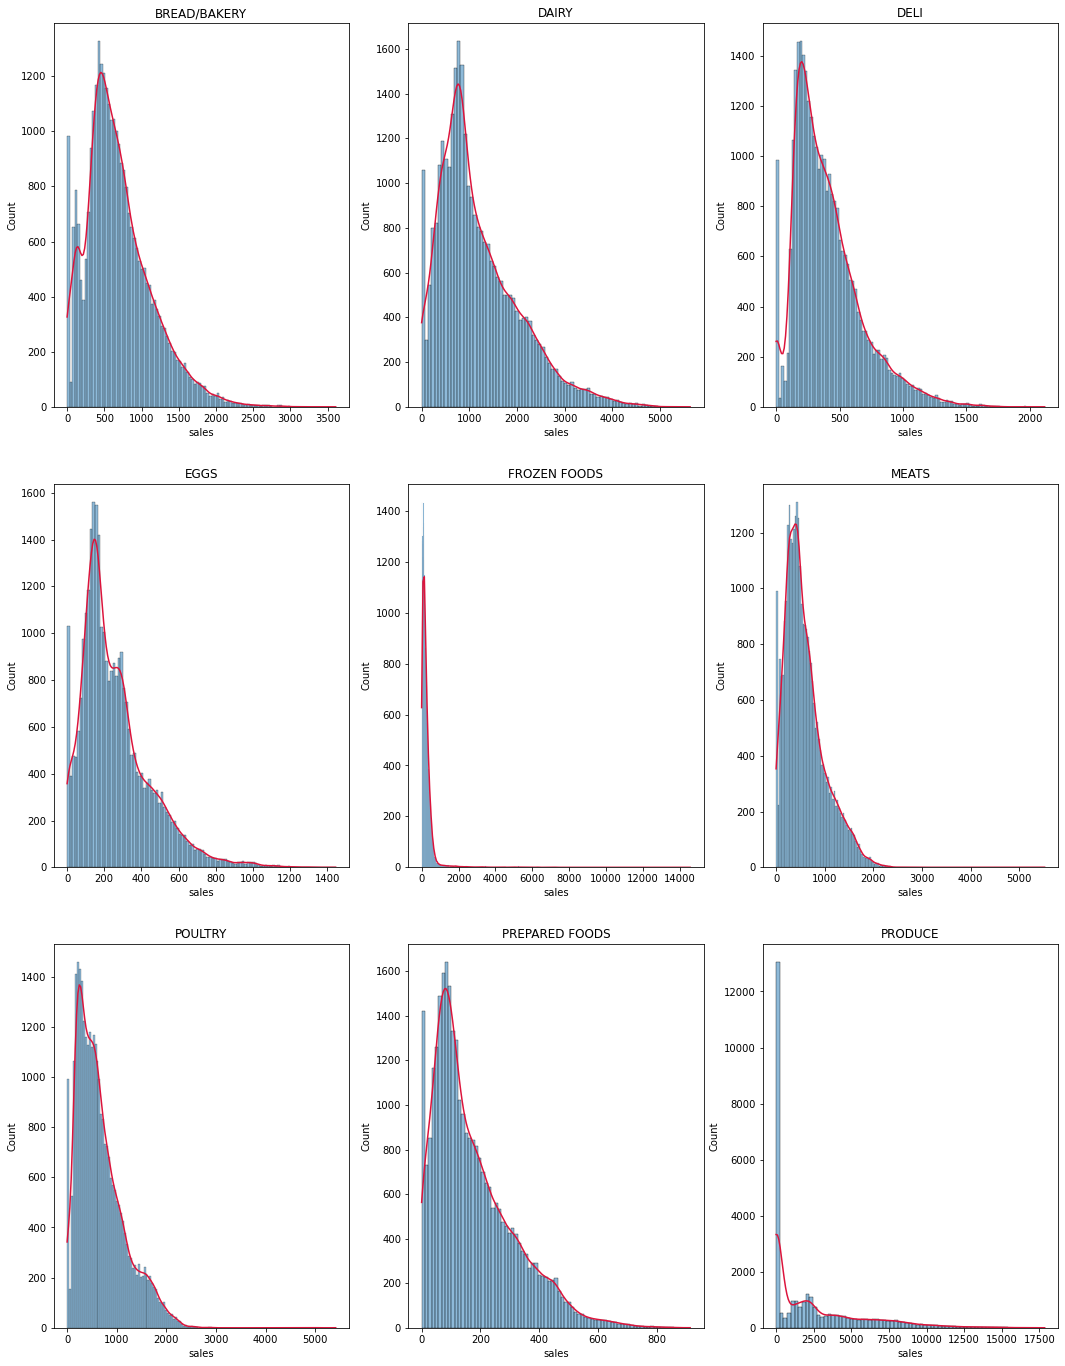

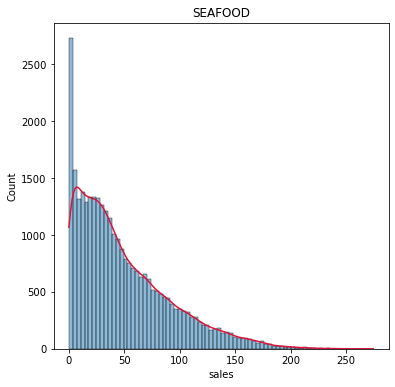

In [4]:
# Distribution: Average Sale

# create a 3x3 grid of subplots
f, axes = plt.subplots(3, 3, figsize=(18, 24))

# list of 'family' names for the header
family_names = ['BREAD/BAKERY', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 
                'MEATS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE']

# plot histograms for each 'family' in the grid
for i, family in enumerate(family_names):
    row = i // 3
    col = i % 3
    ax = sb.histplot(data=csv[csv['family'] == family], x='sales', ax=axes[row, col], kde=True)
    ax.lines[0].set_color('crimson')
    axes[row, col].set_title(family)
    
f, axes = plt.subplots(1, 1, figsize=(6, 6))
    
# plot histogram for 'SEAFOOD' outside the grid
seafood_plot = sb.histplot(data=csv[csv['family'] == 'SEAFOOD'], x='sales', kde=True)
seafood_plot.lines[0].set_color('crimson')
seafood_plot.set_title('SEAFOOD')

# display the plots
plt.show()

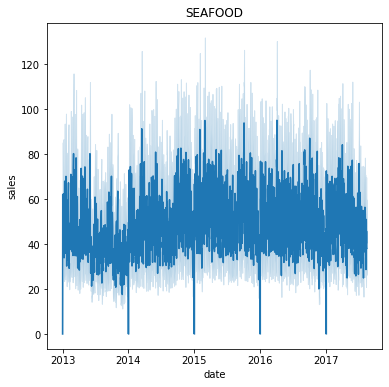


From analysis, it is hard to draw any conclusions from the graph.


In [5]:
# LinePlot (Daily) of 'SEAFOOD'

f, axes = plt.subplots(1, 1, figsize=(6, 6))
seafood_plot = sb.lineplot(data=csv[csv['family'] == 'SEAFOOD'], x='date', y='sales')
seafood_plot.set_title('SEAFOOD')
plt.show()
print("\nFrom analysis, it is hard to draw any conclusions from the graph.")

In [6]:
# convert the index to a datetime index
csv.set_index('date', inplace=True)

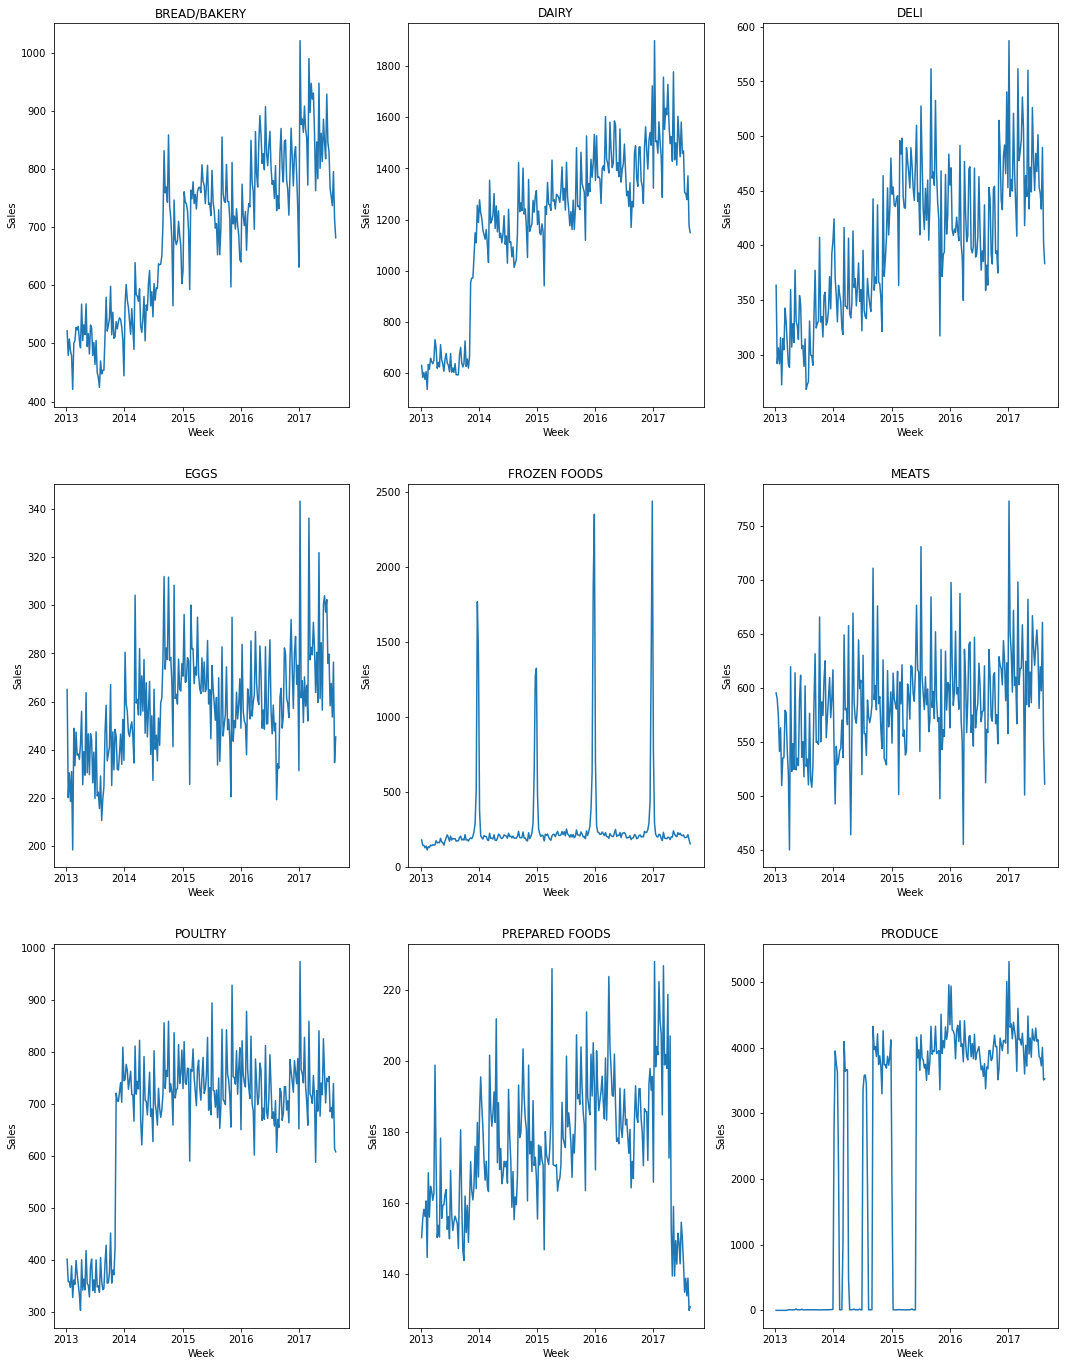

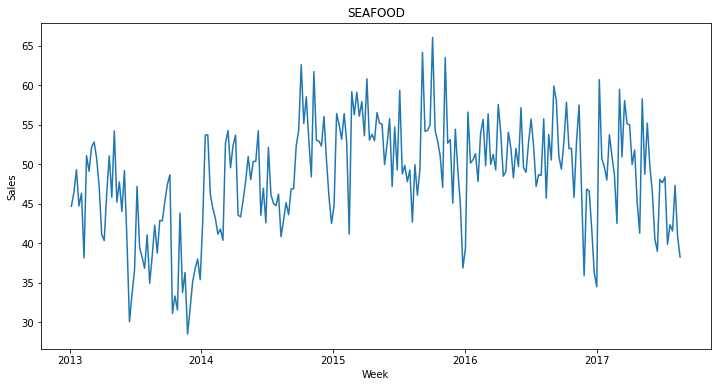

In [7]:
# LinePlot (Weekly)

# create a 3x3 grid of subplots
f, axes = plt.subplots(3, 3, figsize=(18, 24))

# list of family names for the plots
family_names = ['BREAD/BAKERY', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 
                'MEATS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE']

# iterate through the families and plot the weekly sales for each
for i, family in enumerate(family_names):
    row = i // 3
    col = i % 3
    # filter for the family
    family_data = csv[csv['family'] == family]
    # group by week and calculate mean sales
    weekly_sales = family_data.resample('W').agg({'sales':'mean'})
    # plot the line chart
    sb.lineplot(data=weekly_sales, x=weekly_sales.index, y='sales', ax=axes[row, col])
    # set the title for the subplot
    axes[row, col].set_title(family)
    # set the x-label for the subplot
    axes[row, col].set_xlabel('Week')
    # set the y-label for the subplot
    axes[row, col].set_ylabel('Sales')

# filter for the 'SEAFOOD' family
family_data = csv[csv['family'] == 'SEAFOOD']

# group the data by week and calculate the mean sales for each week
weekly_sales = family_data.resample('W').agg({'sales':'mean'})

# create a line plot of weekly sales for the 'SEAFOOD' family
f, ax = plt.subplots(1, 1, figsize=(12, 6))
sb.lineplot(data=weekly_sales, x=weekly_sales.index, y='sales', ax=ax)
ax.set_title('SEAFOOD')
ax.set_xlabel('Week')
ax.set_ylabel('Sales')
plt.show()

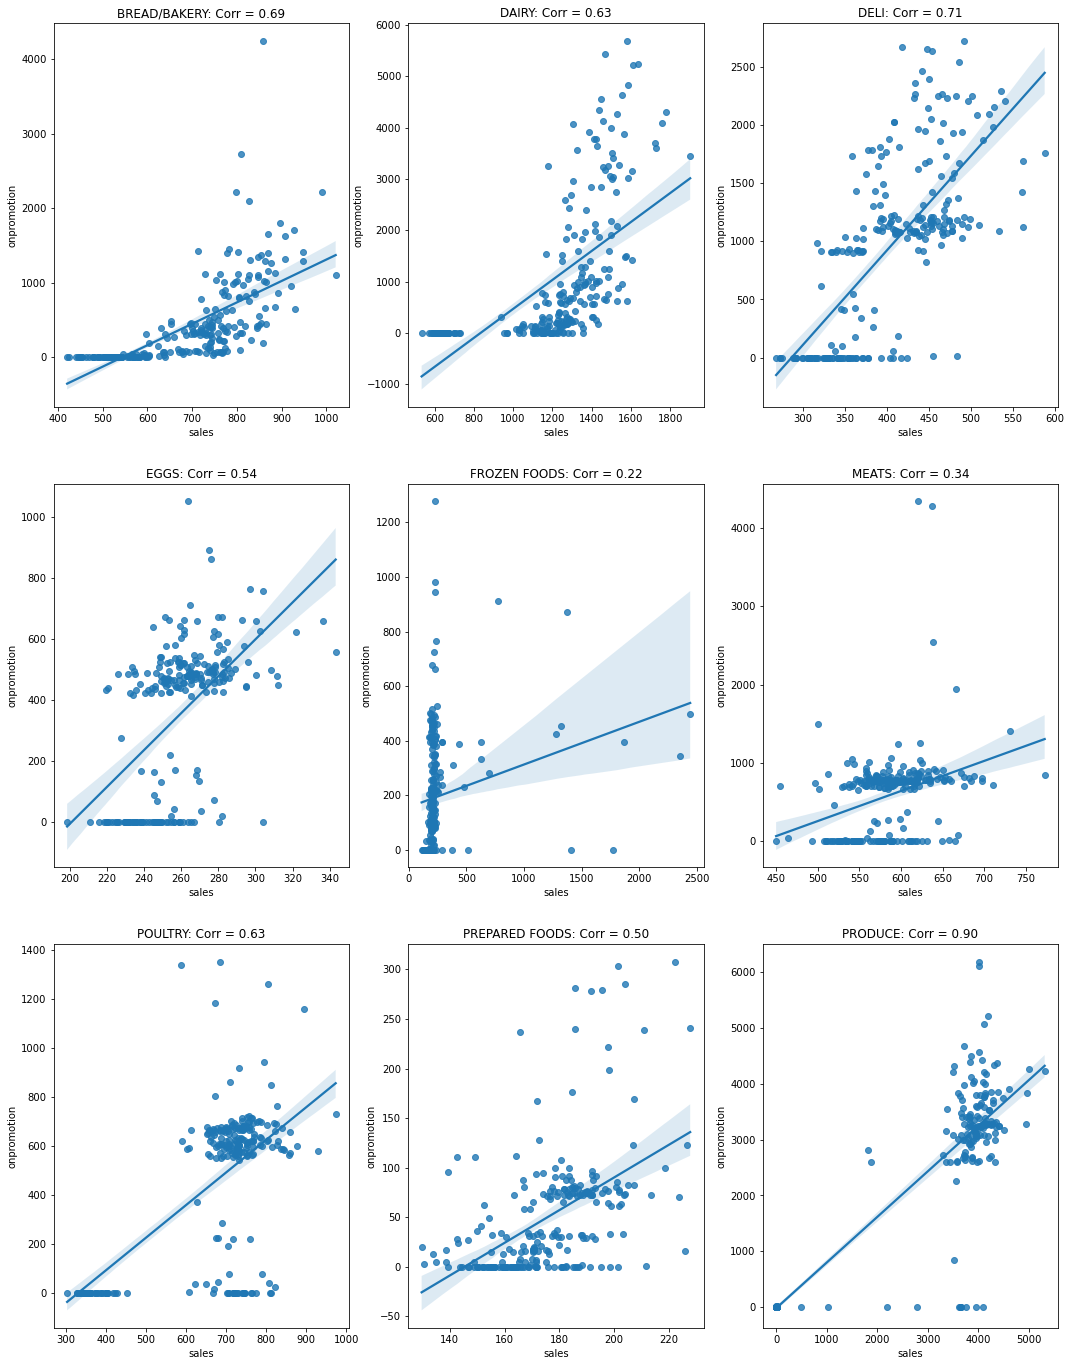

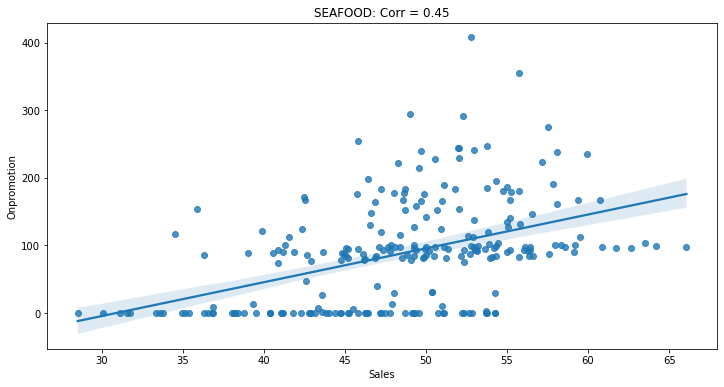

In [8]:
# Correlation of Onpromotion vs Sales (Weekly)

# List of family names for the plots
family_names = ['BREAD/BAKERY', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 
                'MEATS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE']

# Create a 3x3 grid of subplots
f, axes = plt.subplots(3, 3, figsize=(18, 24))

# Iterate through the families and plot the weekly sales for each
for i, family in enumerate(family_names):
    row = i // 3
    col = i % 3
    # Filter for the family
    family_data = csv[csv['family'] == family]
    # Group by week and calculate mean sales and onpromotion counts
    weekly_sales = family_data.resample('W').agg({'sales':'mean', 'onpromotion':'sum'})
    # Calculate the correlation coefficient
    corr_coef = weekly_sales['sales'].corr(weekly_sales['onpromotion'])
    # Create the scatter plot with best fit line and correlation coefficient
    sb.regplot(data=weekly_sales, x='sales', y='onpromotion', ax=axes[row, col])
    axes[row, col].set_title(f'{family}: Corr = {corr_coef:.2f}')
    
# Filter for the 'SEAFOOD' family
family_data = csv[csv['family'] == 'SEAFOOD']
# Group by week and calculate mean sales and onpromotion counts
weekly_sales = family_data.resample('W').agg({'sales':'mean', 'onpromotion':'sum'})
# Calculate the correlation coefficient
corr_coef = weekly_sales['sales'].corr(weekly_sales['onpromotion'])
# Create the scatter plot with best fit line and correlation coefficient in title
f, ax = plt.subplots(1, 1, figsize=(12, 6))
sb.regplot(data=weekly_sales, x='sales', y='onpromotion', ax=ax)
ax.set_title(f'SEAFOOD: Corr = {corr_coef:.2f}')
ax.set_xlabel('Sales')
ax.set_ylabel('Onpromotion')

# Show the plot
plt.show()

In [9]:
# Select one "Bread" category and data from store 1 
df = csv[csv["family"] == "BREAD/BAKERY"]
df = df[df["store_nbr"] == 1]

# Print df info
df.info()
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1714 entries, 2013-01-01 to 2017-08-15
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1714 non-null   float64
 1   store_nbr    1714 non-null   float64
 2   family       1714 non-null   object 
 3   sales        1714 non-null   float64
 4   onpromotion  1714 non-null   float64
 5   holiday      1714 non-null   float64
dtypes: float64(5), object(1)
memory usage: 93.7+ KB


,id,store_nbr,family,sales,onpromotion,holiday
date,,,,,,
2013-01-01,5.0,1.0,BREAD/BAKERY,0.00000,0.0,1.0
2013-01-02,1787.0,1.0,BREAD/BAKERY,470.65200,0.0,0.0
2013-01-03,3569.0,1.0,BREAD/BAKERY,310.65500,0.0,0.0
2013-01-04,5351.0,1.0,BREAD/BAKERY,198.36600,0.0,0.0
2013-01-05,7133.0,1.0,BREAD/BAKERY,301.05700,0.0,1.0
...,...,...,...,...,...,...
2017-08-11,2991983.0,1.0,BREAD/BAKERY,145.60700,8.0,1.0
2017-08-12,2993765.0,1.0,BREAD/BAKERY,243.22000,6.0,0.0
2017-08-13,2995547.0,1.0,BREAD/BAKERY,136.67900,6.0,0.0


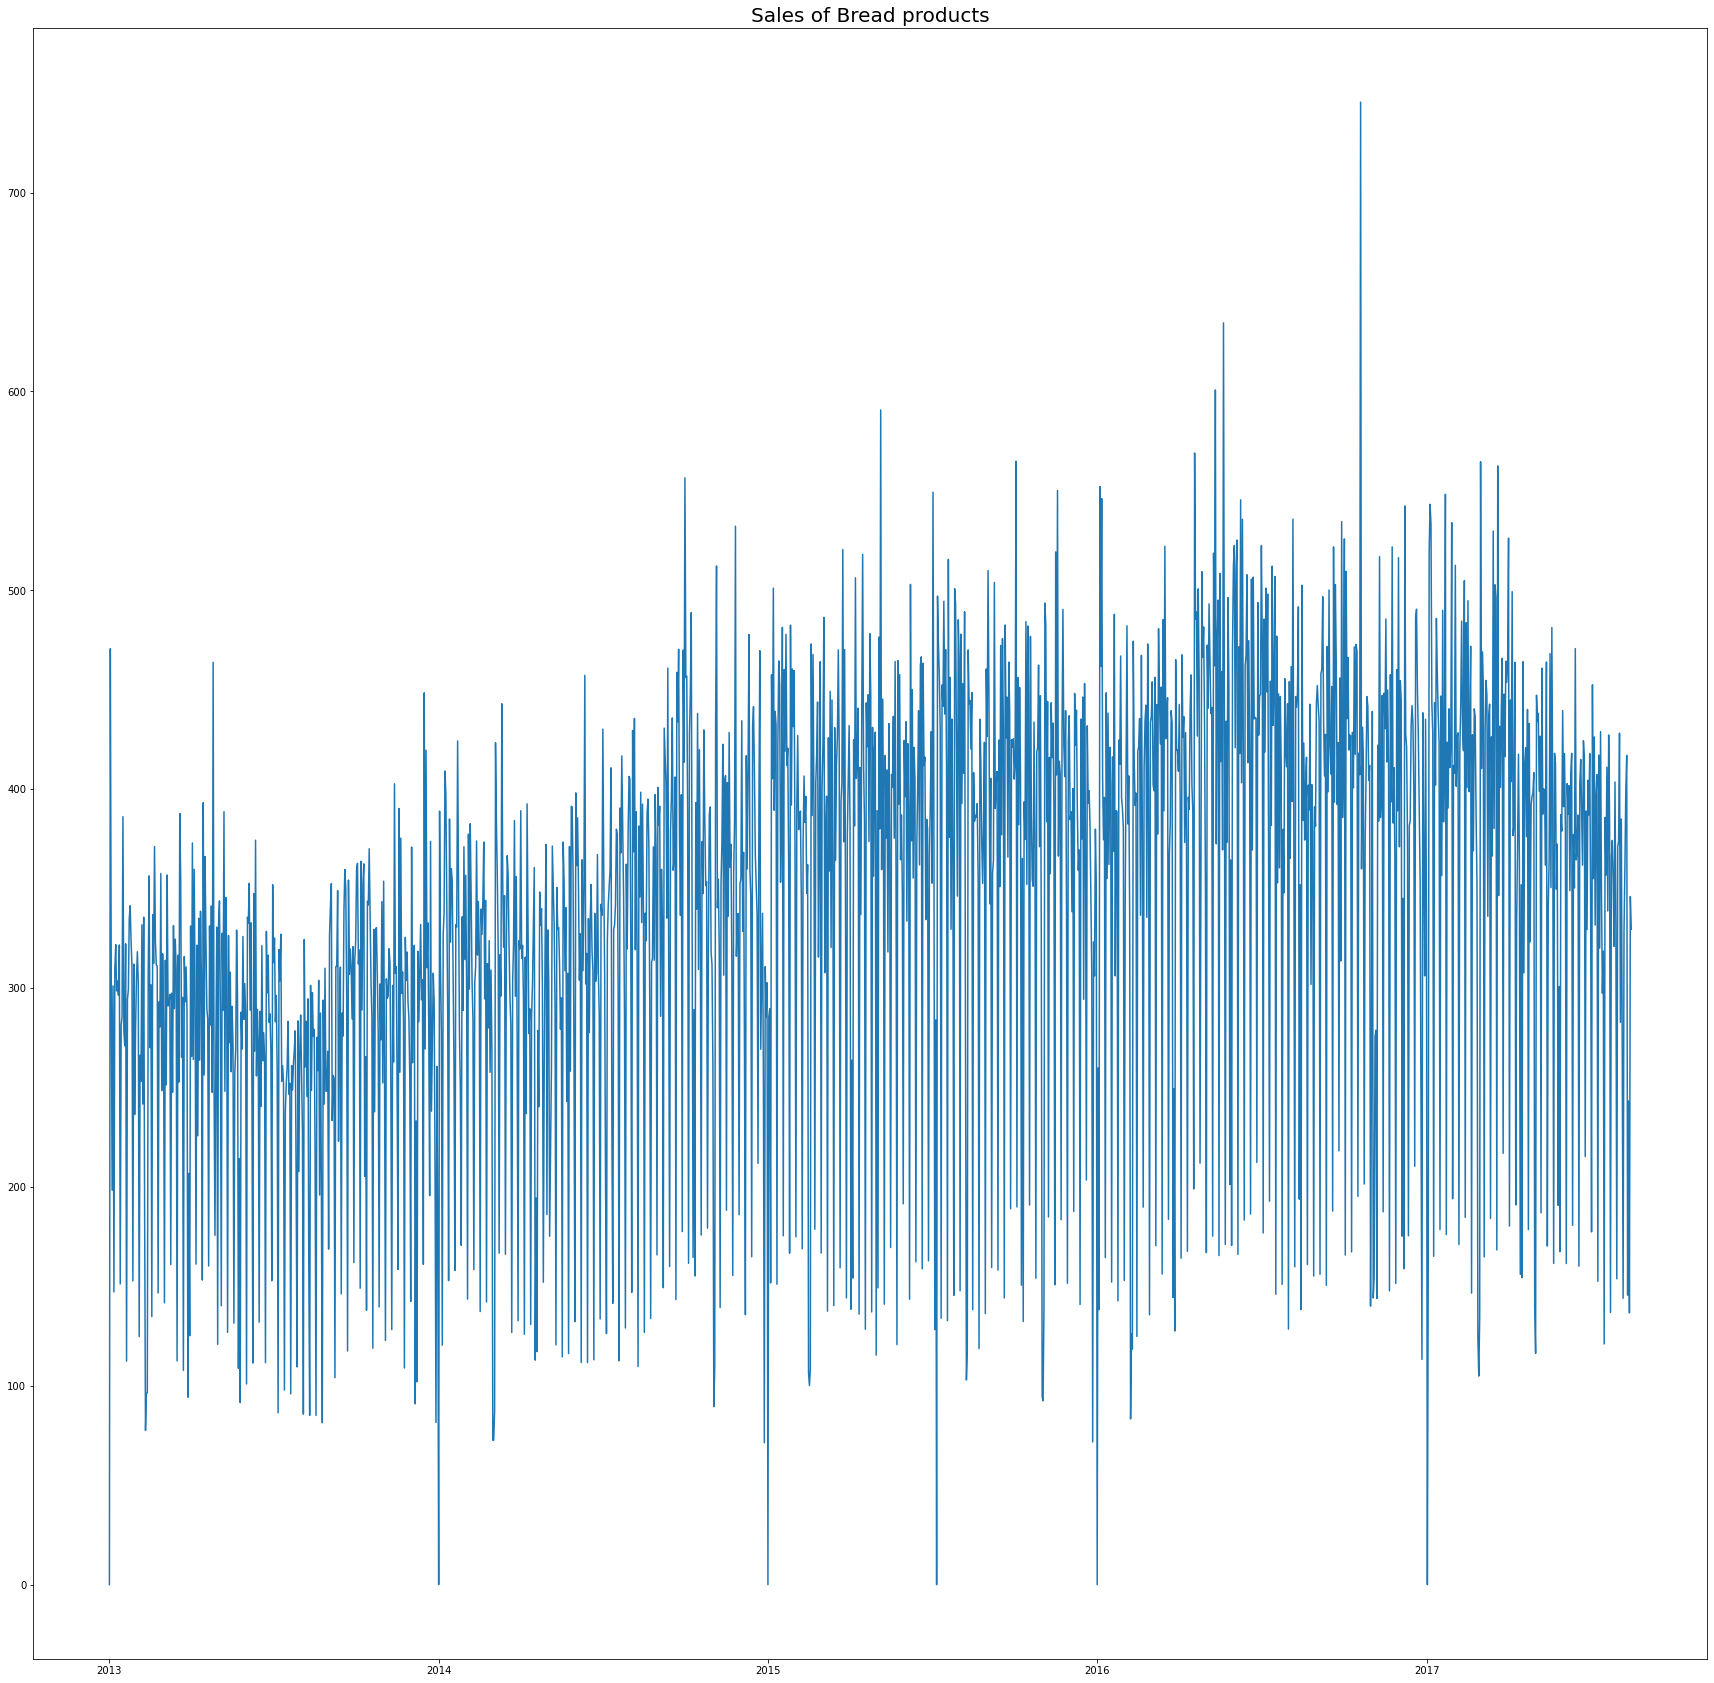

In [10]:
# Plot time series sales data
plt.figure(figsize=(30,30))
plt.title("Sales of Bread products", size=20)
plt.plot(df["sales"])

The plot shows the sales from bread/bakery products from Jan 2013 to Sep 2014, with the time plotted in days. As this time series is not that meaningful (too much data squeezed), we are going to scale the time from days to weeks and take the mean sales of a day in each week. This is just for data exploration and visualisation, the training data will still be in days later on.

                 sales  onpromotion  holiday
date                                        
2013-01-06  237.985333          0.0      2.0
2013-01-13  286.136854          0.0      1.0
2013-01-20  276.780999          0.0      0.0
2013-01-27  293.942143          0.0      0.0
2013-02-03  268.453429          0.0      0.0
...                ...          ...      ...
2017-07-23  348.582143          0.0      1.0
2017-07-30  328.990434          0.0      2.0
2017-08-06  322.335140         26.0      1.0
2017-08-13  290.266857         54.0      2.0
2017-08-20  337.789510         17.0      1.0

[242 rows x 3 columns]


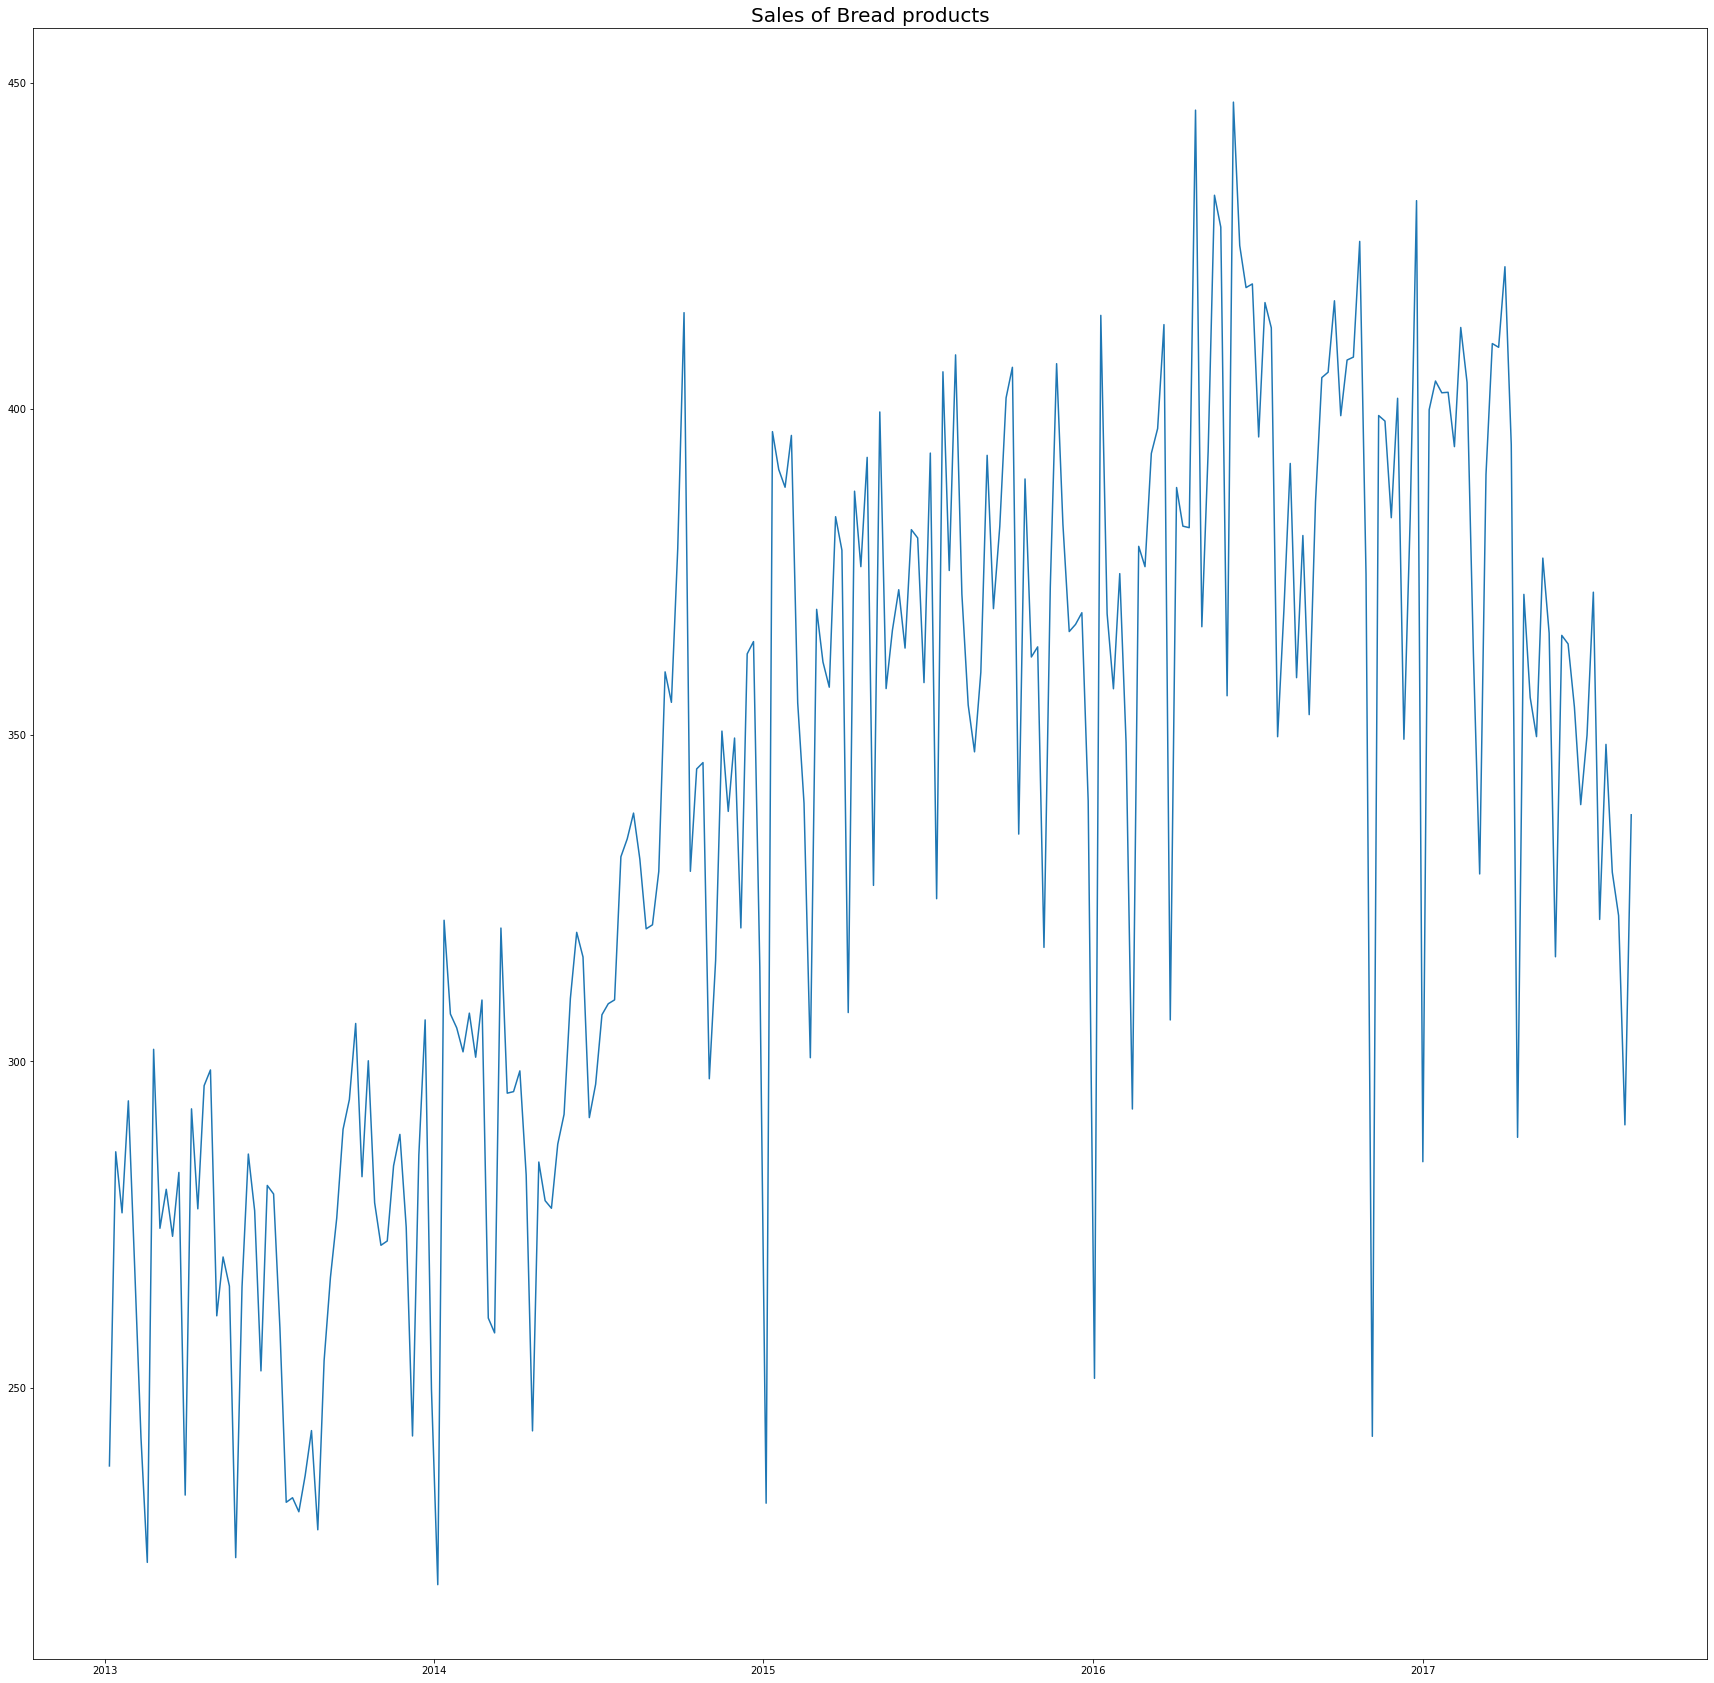

In [11]:
# Scale date range from days to week. Sales for the week is the mean
resampled_df = df.resample('W').agg({'sales':'mean','onpromotion':'sum','holiday':'sum'})
print(resampled_df)

# Plot time series sales data
plt.figure(figsize=(30,30))
plt.title("Sales of Bread products", size=20)
plt.plot(resampled_df['sales'])

From the plot, we can have a better visualisation of the how the estimated data is trending. By observation, it is clear that the sale price of the time series is non-stationary. This means that the sales vary with time as the mean and variance changes overtime. This makes it hard to do time-series forecasting as time is a variable that affects the predictions.

In [12]:
# Data summary
print("MEDIAN: ", df["sales"].median())
print("MEAN: ", df["sales"].mean())
print("SD: ", df["sales"].std())
print("MAX: ", df["sales"].max())
print("Min: ", df["sales"].min())


MEDIAN:  357.446
MEAN:  338.125526757877
SD:  111.29214845117687
MAX:  745.513
Min:  0.0


In [13]:
#sb.boxplot(df["sales"], orient="h")

---
<p style = "font-size: 30px; color: brown">Intro to ARIMA model</p> <br>
ARIMA model is a combination of other models: Auto Regressive(AR), Integrated (I), Moving average(MA). Hence the name ARIMA.

1) Auto Regressive(AR)
The AR model is a regression model that predicts the dependent variable(y) using a past y values.

2) Moving Average(MA)
The MA model analyses the errors of the predicted values of the past values and tries to make a better estimate of the current time values.

3) Integrated (I)
Integrated is not a model but a way to deal with the trend of the data. The 2 models above(AR and MA) assumes that the data is stationary to begin with. Stationary here means 3 conditions are satisfied: 1) Mean is constant, 2) Standard Deviation is constant 3) Seasonality dosen't exist. 

So if the data we have is not stationary, than the I component comes in to make the data stationary so that AR and MA models can be used.


In this notebook, we are focused on finding the hyper-parameters for the AR, I, MA so that we can train the best model.

---

<p style = "font-size: 30px; color: brown">Stationarity of data (I-value)</p> <br>

As mentioned above, stationarity is making sure there is no data trend so that the model can predict the results more accurately. (Just think about it, it is easier to predict a new value when it does not differ too much from the old value, compared to when the new value differs alot from the old value.) 

So from the plot above, we can tell that the data we have is not stationary by observation. (Sale of the store is increasing as time goes on) But a more accurate way to tell if the data is stationary or not is using a statiscal test called KPSS test.

In [14]:
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [15]:
# KPSS test
kpss_test(resampled_df["sales"])

Results of KPSS Test:
Test Statistic           1.989824
p-value                  0.010000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The results can be defined as follows:
- If the "test statistic" is greater than the critical value, we reject the null hypothesis (series is not stationary). 
- If the test statistic is less than the critical value, if fail to reject the null hypothesis (series is stationary). 

For our data, the value of the "test statistic" (1.992437) is greater than the critical value at all confidence intervals.Therefore, the series is not stationary and we need to make the data stationary using a method called "differencing".

---

<p style = "font-size: 30px; color: brown">Differencing</p> <br>
Differencing removes the trend in the data and we do it by simply minusing the previous value from its next value. This will make the data stationary.

In [16]:
# Split train test
size = round(len(resampled_df)*0.8)

train, test = resampled_df[0:size], resampled_df[size:len(resampled_df)]
print(train,'\n', test)
print(len(test))

                 sales  onpromotion  holiday
date                                        
2013-01-06  237.985333          0.0      2.0
2013-01-13  286.136854          0.0      1.0
2013-01-20  276.780999          0.0      0.0
2013-01-27  293.942143          0.0      0.0
2013-02-03  268.453429          0.0      0.0
...                ...          ...      ...
2016-08-21  380.598714         31.0      1.0
2016-08-28  353.142571         17.0      1.0
2016-09-04  385.760571         34.0      0.0
2016-09-11  404.805143         52.0      0.0
2016-09-18  405.633000         49.0      0.0

[194 rows x 3 columns] 
                  sales  onpromotion  holiday
date                                        
2016-09-25  416.577286         57.0      0.0
2016-10-02  398.965429         37.0      1.0
2016-10-09  407.494000          3.0      2.0
2016-10-16  407.945143          4.0      0.0
2016-10-23  425.679859          9.0      0.0
2016-10-30  374.680857         34.0      0.0
2016-11-06  242.522711       

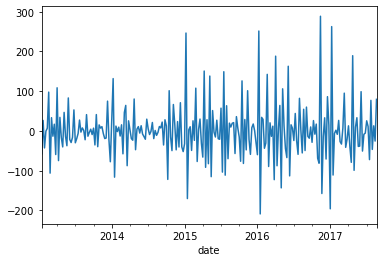

In [17]:
difference_df = resampled_df.copy(deep=True)

difference_df["sales"] = difference_df["sales"].diff()
difference_df["sales"] = difference_df["sales"].diff()

difference_df["sales"].dropna().plot()
difference_df = difference_df[["sales", "onpromotion"]].dropna()

After differencing, it can be observed that the trend in the data is removed.

In [18]:
kpss_test(difference_df["sales"])

Results of KPSS Test:
Test Statistic            0.090862
p-value                   0.100000
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


When we perform KPSS test again, we can see that "test statistic" is now lower than the critical values at all confidence intervals, so the data is now stationary. 

And this is how we find our I value. It is the number of times we do differencing. Note that even though we might have achieve stationary after differencing once, we find that our model improves with more differencing done. In our case is 2.

---

<p style = "font-size: 30px; color: brown">Finding MA value</p> <br>
Now that we found our I value, we proceed to find the value for MA. We use Auto co-relation(ACF) for this. ACF analyses the co-relation a time series and a lagged version of itself. Take for example the image below:


![ACF.png](attachment:846ffe02-1e87-4ee6-9712-4f4cf89be1c0.png)

The price in March (M) can be directly affected by the price in February (F), which is directly affected by January(J). Hence January indirectly affects March. However, January's price can also directly affect March's price. So ACF tells us which lagged period best co-relates to the current time. (Does the price in Jan(t-2) better predicts March or does the price in Feb(t-1) predicts better)

(Image taken from: https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c)

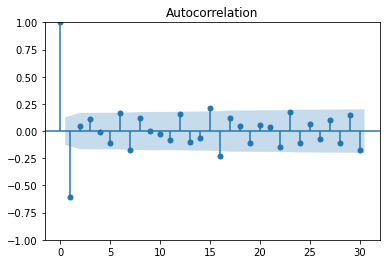

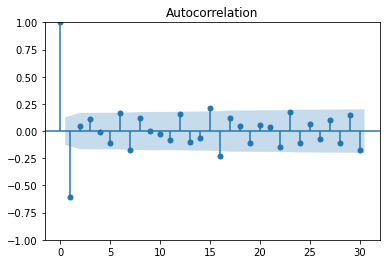

In [19]:
# ACF test
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(difference_df["sales"], lags = 30)

So from the ACF plot, we can ignore lag=0 as that is the corelation between the timeseries and itself, so it will always be one. We can see that the highest corelation is at lag=1, so that is our value for MA. The corelation is the blue box can be ignored as anything in the blue box is considered to be corelation = 0.


---

<p style = "font-size: 30px; color: brown">Finding AR value</p> <br>
To find AR value, it is similar to finding the value for MA but now we use Partial Auto co-relation (PACF). PACF takes away the indirect effects and just focuses on the direct effects of past time on current time. (In the example above, how price of Jan affect price of March.)

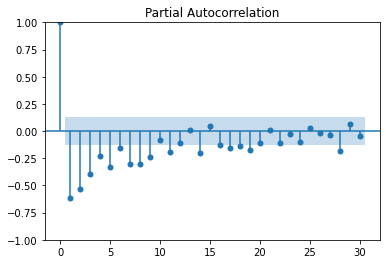

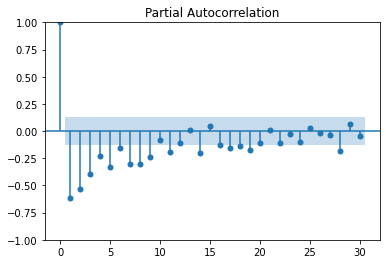

In [20]:
# PACF test
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(difference_df["sales"], lags = 30, method = "ols")

Similar to ACF, we ignore lag=0 and find the highest corelation which is at lag=1. So that is our value for AR. 

---

<p style = "font-size: 30px; color: brown">Prediction</p> <br>
Now that we found our values for AR,I,MA. We can train the model and predict. 

(Note that the ARIMA function given by statsmodel already does the differencing for us in the function, so we only need to feed in the raw data, not the differenced data.)

In [21]:
# predict

history = [x for x in train["sales"]]
predictions = []

for t in range(len(test)):
    
    model = ARIMA(history, order=(1,3,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test["sales"][t]

    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


predicted = 417.606747, expected = 416.577286
predicted = 421.081461, expected = 398.965429
predicted = 398.808284, expected = 407.494000
predicted = 399.554203, expected = 407.945143
predicted = 413.221213, expected = 425.679859
predicted = 432.555025, expected = 374.680857
predicted = 366.028675, expected = 242.522711
predicted = 158.980091, expected = 398.989250
predicted = 372.470228, expected = 398.140286
predicted = 496.119192, expected = 383.326571
predicted = 376.707813, expected = 401.633857
predicted = 399.637951, expected = 349.374000
predicted = 339.727190, expected = 383.425571
predicted = 364.370570, expected = 431.926000
predicted = 471.785173, expected = 284.616143
predicted = 255.853823, expected = 399.878714
predicted = 347.642503, expected = 404.280141
predicted = 477.975140, expected = 402.477143
predicted = 404.293731, expected = 402.554571
predicted = 401.264745, expected = 394.220000
predicted = 390.823105, expected = 412.487286
predicted = 414.226502, expected =

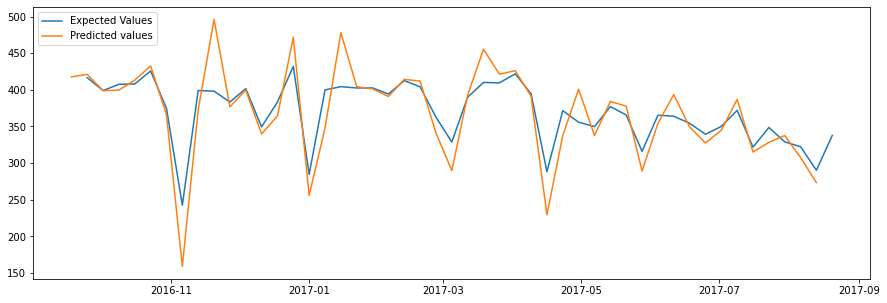

In [22]:
predictions_series = pd.Series(predictions, index = test.index.shift(-1))
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(test["sales"],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted values');
plt.legend(loc="upper left")
plt.show()

This is the results of the model.

---

<p style = "font-size: 30px; color: brown">Evaluate using RMSE</p> <br>

In [23]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(predictions_series, test['sales'], squared=False)
print("RMSE: ", rmse)

RMSE:  70.65259201661559


---
<p style = "font-size: 30px; color: brown">Adding of exog variables</p> <br>
Up till now, we are just using past values to predict the new values. But we also have other variables("number of items on promotion" and "holiday") that seem to have correlation on the sales price. So we try to add in these 2 

In [24]:
# predict

exog_history = [x for x in train["sales"]]
exog_history_exog = [x for x in train[["onpromotion", "holiday"]].to_numpy()]
exog_predictions = []
exog_future_exog = [x for x in test[['onpromotion', "holiday"]].to_numpy()]

for t in range(len(test)):
    
    exog_model = ARIMA(exog_history, order=(1,3,1), exog=exog_history_exog)
    exog_model_fit = exog_model.fit()
    
    exog_output = exog_model_fit.forecast(exog=exog_future_exog[t])
    exog_yhat = exog_output[0]
    exog_predictions.append(float(exog_yhat))
    obs = test["sales"][t]

    exog_history.append(obs)
    exog_history_exog.append(exog_future_exog[t])
    
    print('predicted = %f, expected = %f' % (exog_yhat, obs))

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


predicted = 417.823948, expected = 416.577286
predicted = 412.519753, expected = 398.965429
predicted = 392.481776, expected = 407.494000
predicted = 421.612351, expected = 407.945143
predicted = 414.625008, expected = 425.679859
predicted = 425.107654, expected = 374.680857
predicted = 339.574816, expected = 242.522711
predicted = 164.468952, expected = 398.989250
predicted = 424.161777, expected = 398.140286
predicted = 485.749720, expected = 383.326571
predicted = 358.564621, expected = 401.633857
predicted = 387.571719, expected = 349.374000
predicted = 367.115809, expected = 383.425571
predicted = 328.816510, expected = 431.926000
predicted = 485.804423, expected = 284.616143
predicted = 294.795040, expected = 399.878714
predicted = 333.432113, expected = 404.280141
predicted = 466.152235, expected = 402.477143
predicted = 399.920340, expected = 402.554571
predicted = 399.696567, expected = 394.220000
predicted = 392.150191, expected = 412.487286
predicted = 410.194755, expected =

C:\Users\ASUS\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 417.132324, expected = 421.795571
predicted = 437.648870, expected = 394.529000
predicted = 368.776632, expected = 288.351747
predicted = 260.411814, expected = 371.575571
predicted = 350.674945, expected = 355.761714
predicted = 377.263066, expected = 349.771714
predicted = 317.268027, expected = 377.135571
predicted = 417.255683, expected = 365.636000
predicted = 366.627454, expected = 316.029571
predicted = 295.615468, expected = 365.291429
predicted = 354.751487, expected = 363.984714
predicted = 386.033486, expected = 354.314143
predicted = 321.668046, expected = 339.349444
predicted = 368.811167, expected = 349.996143
predicted = 335.866719, expected = 371.910875
predicted = 386.163760, expected = 321.752286
predicted = 313.456742, expected = 348.582143
predicted = 312.500148, expected = 328.990434
predicted = 357.237502, expected = 322.335140
predicted = 302.937653, expected = 290.266857
predicted = 275.854911, expected = 337.789510


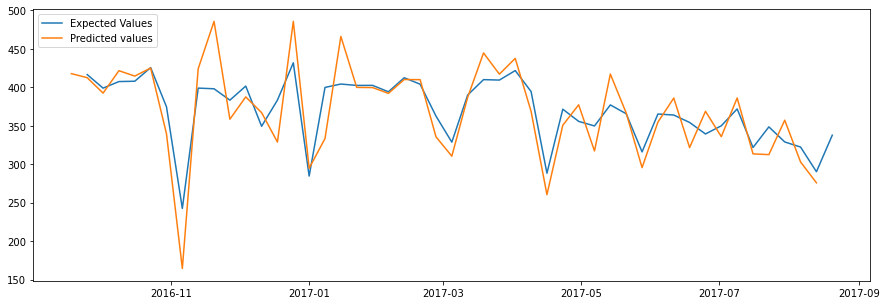

In [25]:
exog_predictions_series = pd.Series(exog_predictions, index = test.index.shift(-1))
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(test["sales"],label = 'Expected Values')
plt.plot(exog_predictions_series,label = 'Predicted values');
plt.legend(loc="upper left")
plt.show()

In [26]:
exog_rmse = mean_squared_error(exog_predictions_series, test['sales'], squared=False)
print("Exog_RMSE: ", exog_rmse)

Exog_RMSE:  66.7087818371288


---
<p style = "font-size: 30px; color: brown">Comparison between with Exog variables and without</p> <br>

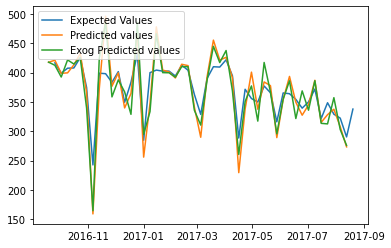

In [27]:
plt.subplot(1,1,1)
plt.plot(test["sales"],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted values');
plt.plot(exog_predictions_series,label = 'Exog Predicted values');
plt.legend(loc="upper left")
plt.show()

In [28]:
rmse = mean_squared_error(predictions_series, test['sales'], squared=False)
exog_rmse = mean_squared_error(exog_predictions_series, test['sales'], squared=False)
print("RMSE: ", rmse)
print("Exog_RMSE: ",exog_rmse)

RMSE:  70.65259201661559
Exog_RMSE:  66.7087818371288


With the inclusion of the exog variables, the model improved slightly.